# Bean Classification Project Proposal 

In [45]:
#run this cell before continuing

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 16)
library(readxl)

# Introduction

This dataset is based on 13611 images of 7 types of individual dry beans with similar features. Each image was analyzed for 16 features of the bean (4 "shape factors", 12 structural/geometric features) (Kolku & Ozkan, 2020).


The question we will be answering is whether we can determine the bean type in an image based on the measured physical measurements of the bean. We will be using K-nearest neighbors classification to predict "Class" using the predictors "Area", and "roundness".

Our variable of intetrest:
- **Area**:The area of a bean zone and the number of pixels within its boundaries.
- **Roundess**: Calculated with the following formula: (4piA)/(P^2)\
Note: P in the roundness area is the Perimeter variable in the dataset. The Perimeter variable is definied as Bean circumference is defined as the length of its border (Kolku & Ozkan, 2020).

# Preliminary exploratory data analysis

In [46]:
beanurl<-"https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"
temp <- tempfile()
download.file(beanurl,temp)
beanzip <- unzip(temp, "DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean <- read_excel(beanzip)
bean

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
30008,645.884,210.5580,182.5165,1.153638,0.4986160,30724,195.4671,0.7826813,0.9766957,0.9039364,0.9283288,0.007016729,0.003214562,0.8617944,0.9941988,SEKER
30140,620.134,201.8479,190.2793,1.060798,0.3336797,30417,195.8965,0.7730980,0.9908933,0.9848771,0.9705155,0.006697010,0.003664972,0.9419004,0.9991661,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
30477,670.033,211.0502,184.0391,1.146768,0.4894779,30970,196.9886,0.7624015,0.9840814,0.8530799,0.9333736,0.006924899,0.003242016,0.8711862,0.9990487,SEKER
30519,629.727,212.9968,182.7372,1.165591,0.5137596,30847,197.1243,0.7706818,0.9893669,0.9671092,0.9254804,0.006979152,0.003158285,0.8565140,0.9983446,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


Splitting the dataset into training and testing

In [47]:
##Creating training and testing dataset

set.seed(2022)
bean_split <- initial_split(bean, prop = 0.75, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

Graphing the training dataset in plot point

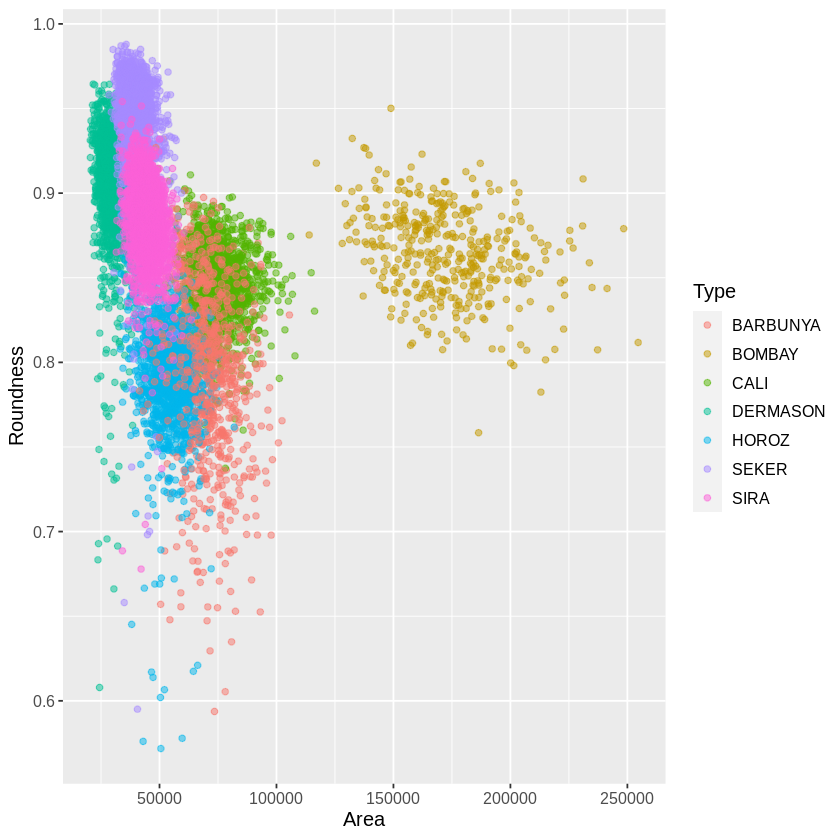

In [48]:
#Graphing the training dataset

area_round_plot <- bean_train |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  theme(text = element_text(size = 12))
area_round_plot

From the point plot of the area vs roundness observation above, we can see that there are big difference between area value and the roundness value, therefore, we will scale the data

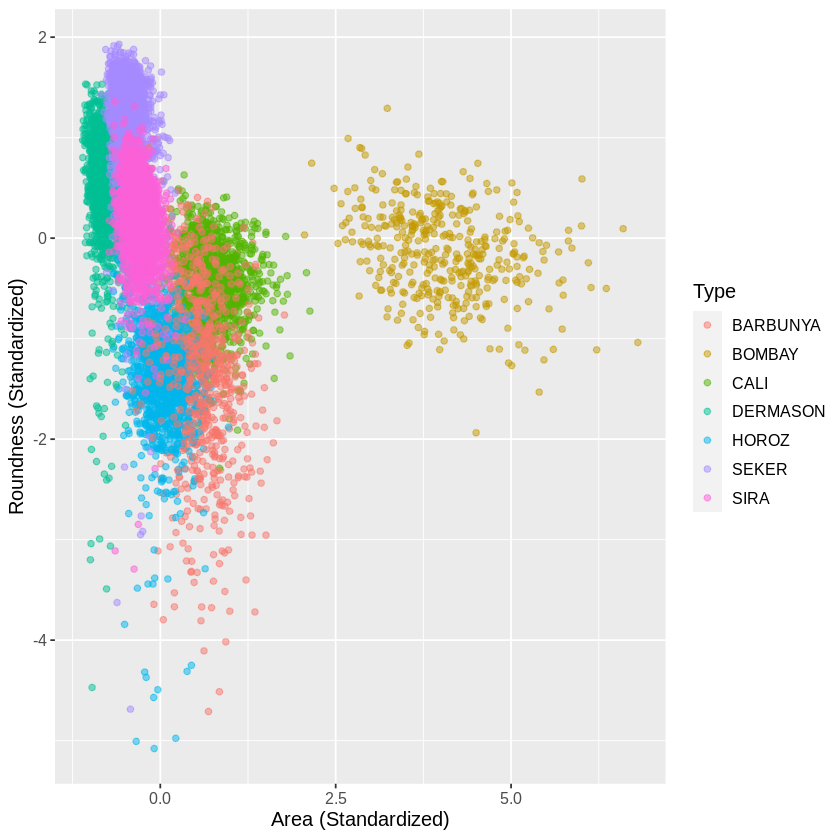

In [49]:
## Scalling all data:
bean_data_training_recipe <- recipe(Class ~ Area + roundness, data = bean_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())
bean_data_training_scaled <- bean_data_training_recipe |>  
                            prep() |> 
                            bake(bean_train)

area_round_plot_scaled <- bean_data_training_scaled |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(alpha = 0.5) +
  labs(x = "Area (Standardized)", 
       y = "Roundness (Standardized)",
       color = "Type") +
  theme(text = element_text(size = 12))
area_round_plot_scaled

The table, and bar chart below show us the distribution of bean types in the training set

In [50]:
#Summarize training dataset
bean_class_dist <- bean_train |>
                group_by(Class)|>
                summarize(count = n()) |>
                mutate(percentage_dist = 100*count/nrow(bean_train))
bean_class_dist

Class,count,percentage_dist
<chr>,<int>,<dbl>
BARBUNYA,996,9.758009
BOMBAY,404,3.958068
CALI,1226,12.011365
DERMASON,2656,26.021358
HOROZ,1431,14.019790
SEKER,1521,14.901538
SIRA,1973,19.329872


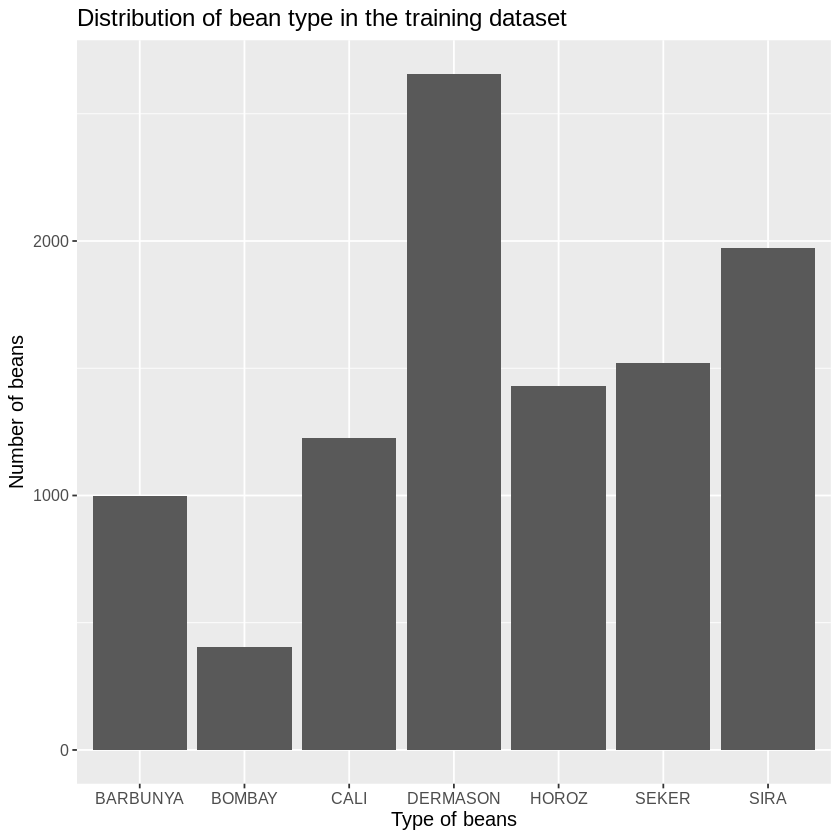

In [51]:
bean_class_dist_plot <- bean_class_dist |>
                        ggplot(aes(x=Class, y = count))+
                        geom_bar(stat = "identity")+
                        labs(x= "Type of beans",
                             y = "Number of beans")+
                        ggtitle("Distribution of bean type in the training dataset")+
                        theme(text = element_text(size = 12))
bean_class_dist_plot

Next we will look at Statistical distribution of our chosen variables, in table and boxplot form

In [42]:
#Statistical Distribution of predictor based on class
features_dist_by_class <- bean_train |>
                group_by(Class)|>
                summarize(max_area = max(Area, na.rm = TRUE),
                          min_area = min(Area, na.rm = TRUE),
                          std_dev_area = sd(Area, na.rm = TRUE),
                          max_roundness = max(roundness, na.rm = TRUE),
                          min_roundness = min(roundness, na.rm = TRUE),
                         std_dev_roundness = sd(roundness, na.rm = TRUE))
features_dist_by_class

Class,max_area,min_area,std_dev_area,max_roundness,min_roundness,std_dev_roundness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,105542,41487,10357.720,0.9319586,0.5937083,0.04890045
BOMBAY,254616,114004,23332.489,0.9501045,0.7584168,0.02679776
CALI,116272,45504,9478.638,0.9200291,0.7374636,0.02357353
DERMASON,42147,20420,4687.943,0.9666028,0.6078674,0.02794460
HOROZ,81929,33263,7297.006,0.9190136,0.5718009,0.03179097
SEKER,59385,28395,4844.331,0.9879197,0.5950484,0.03096804
SIRA,63612,31519,4576.330,0.9541042,0.6778369,0.02341828


In [43]:
#Statistical Distribution in Features of varieties of dry bean
features_dist <- bean_train |>
            select(Area,roundness) |>
            pivot_longer(cols= Area:roundness,
                         names_to = "Features",
                         values_to = "values") |>
            group_by(Features) |>
            summarize(Mean = mean(values, na.rm = TRUE),
                      Min = min(values, na.rm = TRUE),
                      Max = max(values, na.rm = TRUE),
                     Std_Deviation = sd(values, na.rm = TRUE))
features_dist

Features,Mean,Min,Max,Std_Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Area,5.316321e+04,2.042000e+04,2.546160e+05,2.959663e+04
roundness,8.733952e-01,5.718009e-01,9.879197e-01,5.938436e-02


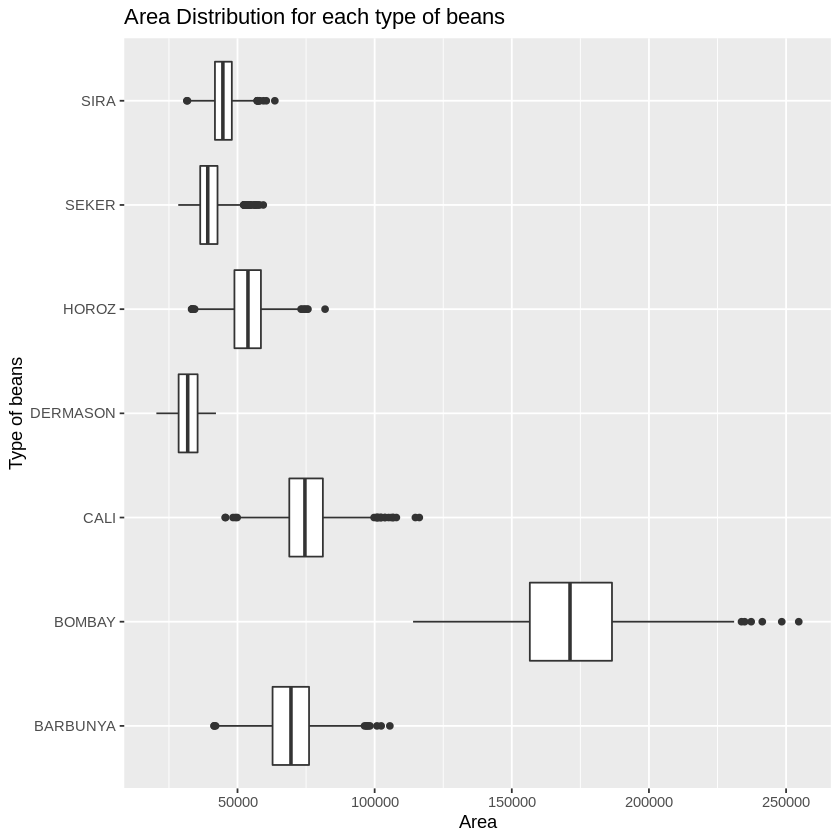

In [12]:
#Graphing area distribution for each type of bean
area_box_plot <- bean_train |>
                ggplot(aes(x = Class, y = Area))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Area")+
                ggtitle("Area Distribution for each type of beans")+
                coord_flip()
area_box_plot

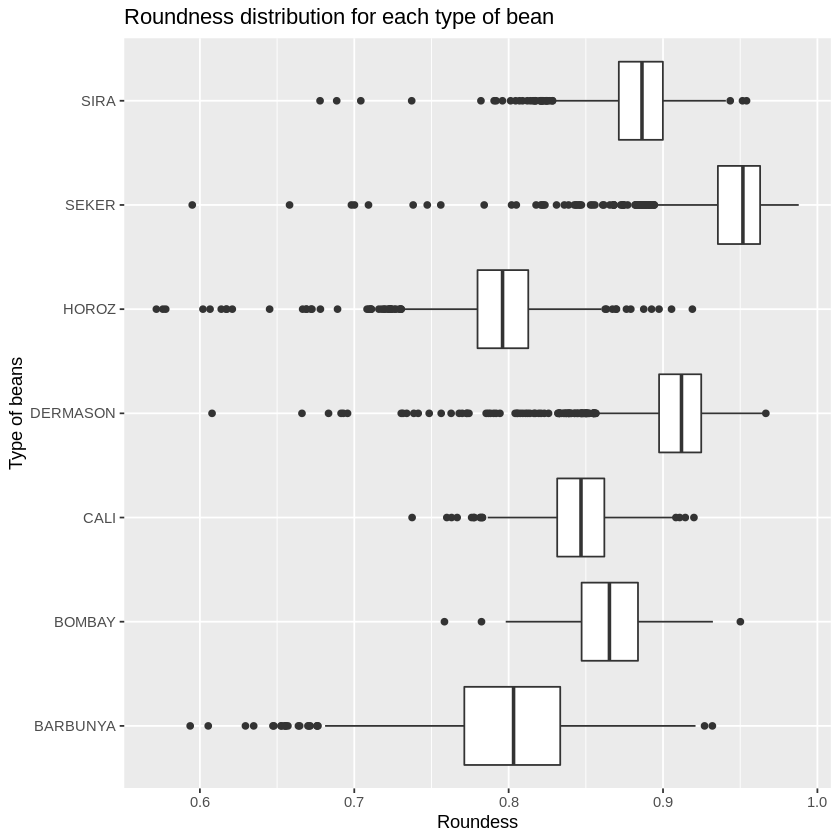

In [17]:
#Graphing box plot showing roundness distribution for each type of box plot
roundness_box_plot <- bean_train |>
                ggplot(aes(x = Class, y = roundness))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Roundess")+
                ggtitle("Roundness distribution for each type of bean")+
                coord_flip()
roundness_box_plot

# Methods
1. Data cleaning
- We will load the raw data set into R and cleaning it. 

2. Visualize Data
- Next, we will create visualizations such as scatterplots to identify any trends or potential outliers in the data.

3. Select Variables
- We will then select two variables: roundness and area as they are the most relevant variables for predicting the type of bean based on the physical dimensions (height and weight). 

4. Model the Data
- We will create a k-nearest neighbors (KNN) classification model using roundness and area as predictors. First, we will split the data into a training set and a testing set. Next, we will perform cross-validation by fitting the KNN model with different values of k on the training set. The testing set (has untrained data) will be used to evaluate the generalizability of the model and avoid bias. By using unseen data, we can assess the model's ability to classify new observations accurately. Finally, the testing data will be used to assess the accuracy of the KNN model for each k value, and the k value with the highest accuracy will be chosen as the optimal parameter for the model.racy as the optimal parameter for our model.

5. Visualization
- We'll make a scatterplot with colored data points for each bean type to visualize the model's performance in separating them based on the two predictors. Additionally, we'll create a confusion matrix to display the model's correct and incorrect predictions for each bean type.


# Expected outcomes and significance

What do we expect to find?
- With the help of a classification model, we expect to find a well-performing model that can predict the type of beans based on their roundness and area with high accuracy. On the visualization, we also expect to see a cluster for different types of bean in various colors.  

What impact could such findings have?
- This classification model can impact the food and agriculture industry. An automated system can be created to classifiy the type of bean based on their physical appearance. This is espcially useful when food and agriculture companies collect different types of beans together, dry them, and want to package them based on different types. The model we built can help to streamline the service, gain quality control and reduce the time for people to manually separate the beans. 

What future questions could this lead to?
- Can other variables such as major axis length or the perimeter be good predictors of the type? And are they better predictors than roundness and area?
- Can the classification model be used for different types of crops such as rice? 

## References:
- Krzywinski, Martin, and Naomi Altman. "Visualizing samples with box plots: use box plots to illustrate the spread and differences of samples." Nature Methods, vol. 11, no. 2, Feb. 2014, pp. 119+. Gale OneFile: Health and Medicine, link.gale.com/apps/doc/A361242515/HRCA?u=ubcolumbia&sid=bookmark-HRCA&xid=0db0fe06. Accessed 11 Mar. 2023.

- Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507